c:\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 128)        │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,417 (798.50 KB)

 Trainable params: 204,417 (798.50 KB)

 Non-trainable params: 0 (0.00 B)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

          CONSOLIDATED MODEL PERFORMANCE SUMMARY         
    (Trained on Hourly Data, Tested on delhi_test_daily.csv)  
Metric                 Multivariate LSTMXGBoost (Multivariate)SARIMAX (AQI + Exogenous Pollutants)
--------------------------------------------------------------------------------
MAE                                24.78               36.37               69.15
MAPE                               15.59%               27.13%               57.42%
RMSE                               31.98               43.89               76.21
R2                                0.8266              0.6734              0.0151
Category Accuracy                  72.78%               65.09%               34.32%


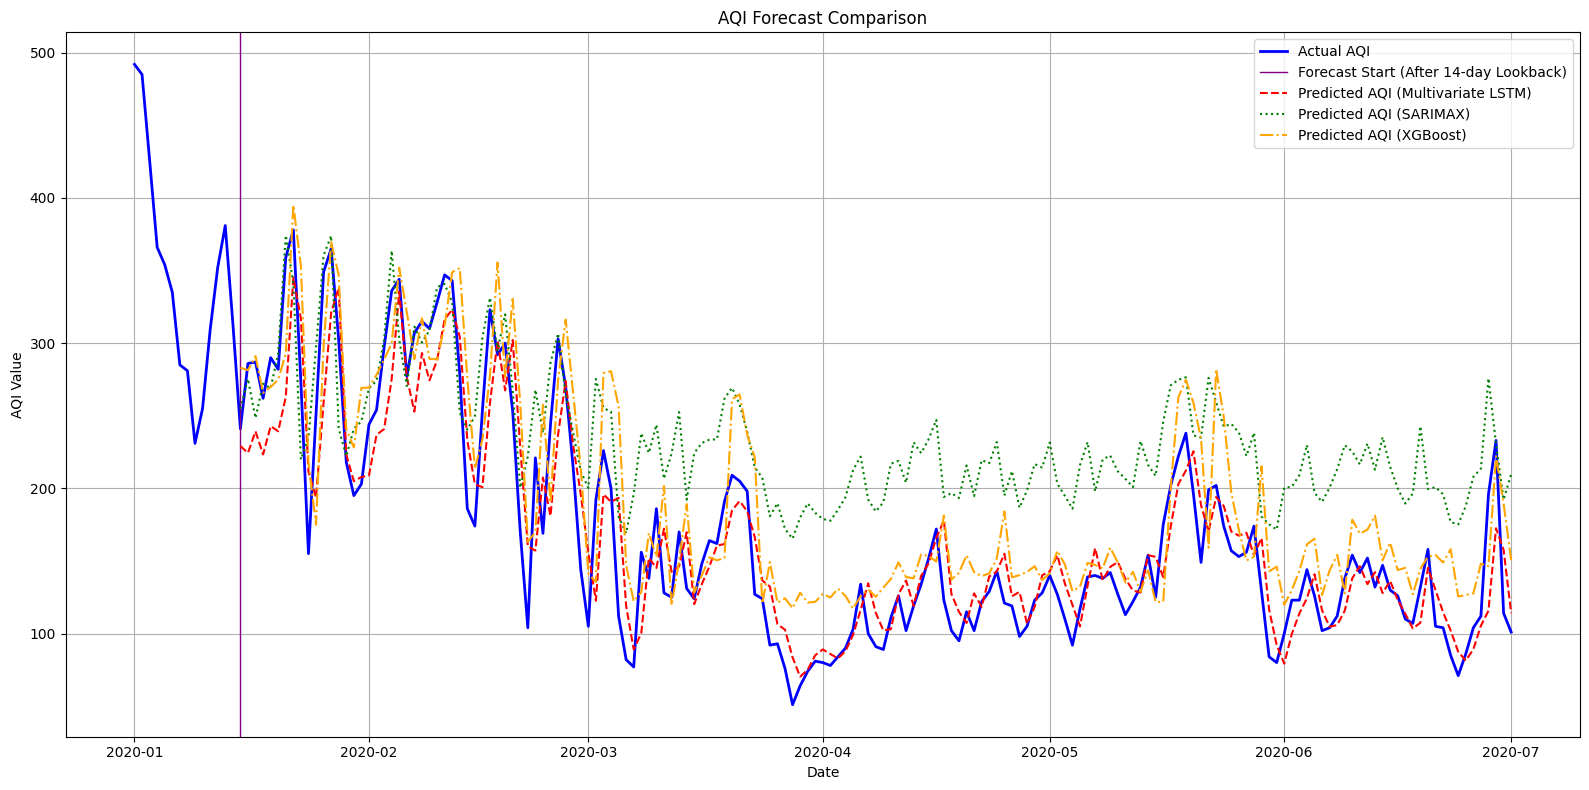

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings
from pathlib import Path

# Suppress Convergence Warnings from statsmodels for cleaner output
warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)


# Base folder containing the CSV files
DATA_DIR = Path("data")

# Input files (automatically read from data/)
TRAIN_FILE = DATA_DIR / "delhi_train_hourly.csv"
VAL_FILE   = DATA_DIR / "delhi_val_daily.csv"
TEST_FILE  = DATA_DIR / "delhi_test2_daily.csv"
# --- Configuration ---
# Filepaths based on your explicit request
#TRAIN_FILE = "delhi_train_hourly.csv"  # Hourly data -> will be aggregated to daily
#VAL_FILE = "delhi_val_daily.csv"       # Daily data -> used for LSTM validation
#TEST_FILE = "delhi_test_daily.csv"     # Daily data -> used for final testing

TARGET_COLUMN = 'AQI'
# Features used as input for the LSTM. We use all pollutant columns plus the target itself.
FEATURES = [
    'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 
    'O3', 'Benzene', 'Toluene', 'Xylene', TARGET_COLUMN
]
LOOK_BACK = 14  # Number of previous days to use for predicting the next day
EPOCHS = 50
BATCH_SIZE = 32
RANDOM_STATE = 42

# Store metrics globally to generate the summary table later
metrics_store = {}

# --- Helper Functions for Evaluation and Metrics (Unchanged) ---

# Define AQI Categories for Accuracy Calculation (as per CPCB/US EPA standards)
AQI_CATEGORIES = {
    'Good': (0, 50),
    'Satisfactory': (51, 100),
    'Moderate': (101, 200),
    'Poor': (201, 300),
    'Very Poor': (301, 400),
    'Severe': (401, 5000) # Use a large upper bound
}

def aqi_to_category(aqi_value):
    """Maps an AQI value to its corresponding category string."""
    for category, (low, high) in AQI_CATEGORIES.items():
        if low <= aqi_value <= high:
            return category
    return 'Unknown'

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculate Mean Absolute Percentage Error (MAPE, robust version)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by replacing 0s in y_true with a very small number
    y_true_safe = np.where(y_true == 0, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

def calculate_category_accuracy(y_true_unscaled, y_pred_unscaled):
    """Calculates the percentage of predictions that fall into the correct AQI category."""
    true_categories = [aqi_to_category(y) for y in y_true_unscaled.flatten()]
    pred_categories = [aqi_to_category(y) for y in y_pred_unscaled.flatten()]
    
    correct_predictions = sum(1 for true, pred in zip(true_categories, pred_categories) if true == pred)
    total_predictions = len(y_true_unscaled)
    
    accuracy = correct_predictions / total_predictions * 100
    return accuracy

def evaluate_predictions(y_true_unscaled, y_pred_unscaled, model_name):
    """Calculates and prints all required metrics, and stores them in the global dictionary."""
    # Ensure all inputs are flat arrays for metric functions
    y_true_unscaled = y_true_unscaled.flatten()
    y_pred_unscaled = y_pred_unscaled.flatten()
    
    # Check for NaN/Inf in predictions before calculating metrics
    if np.any(np.isnan(y_pred_unscaled)) or np.any(np.isinf(y_pred_unscaled)):
        # Replace inf/nan with the mean of the rest of the predictions (crude fix)
        y_pred_unscaled = np.nan_to_num(y_pred_unscaled, nan=np.nanmean(y_pred_unscaled))
        print(f"Warning: NaN/Inf encountered in {model_name} predictions. Replacing with mean for metrics.")

    rmse = np.sqrt(mean_squared_error(y_true_unscaled, y_pred_unscaled))
    mae = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
    r2 = r2_score(y_true_unscaled, y_pred_unscaled)
    mape = mean_absolute_percentage_error(y_true_unscaled, y_pred_unscaled)
    cat_accuracy = calculate_category_accuracy(y_true_unscaled, y_pred_unscaled)

    # Store metrics for the final summary table
    metrics_store[model_name] = {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'R2': r2,
        'Category Accuracy': cat_accuracy
    }

    #print(f"\n--- {model_name} Evaluation Metrics ---")
    #print(f"Mean Absolute Error (MAE): {mae:.2f} AQI Units")
    #print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    #print(f"Root Mean Squared Error (RMSE): {rmse:.2f} AQI Units")
    #print(f"R-squared (R2) Score: {r2:.4f}")
    #print(f"Category Accuracy: {cat_accuracy:.2f}% (Correct category prediction)")
    
    return y_true_unscaled, y_pred_unscaled # Return flat arrays for plotting consistency


# Function to create sequences (X and Y arrays) for the LSTM model
def create_sequences(data, look_back):
    """
    Converts a multivariate time series into input sequences (X) and target outputs (y).
    
    X: [samples, look_back, n_features] for LSTM
    y: [samples, 1] (Target value at t + look_back)
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        # Input features: all columns from t to t + look_back - 1
        X.append(data[i:(i + look_back), :]) 
        # Target: the last column (AQI) at time t + look_back
        y.append(data[i + look_back, -1]) 
    return np.array(X), np.array(y)

# Function to create flat feature matrix for XGBoost
def create_xgb_features(df, look_back):
    """
    Converts a multivariate time series DataFrame into flat features (X) and target (y)
    for traditional ML models like XGBoost.

    X: [samples, look_back * n_features]
    y: [samples, 1] (Target value at t + look_back)
    """
    data = df.values
    n_features = df.shape[1]
    X_flat, y_flat, dates = [], [], []

    for i in range(len(data) - look_back):
        # Input features: flatten the history window (all features)
        X_flat.append(data[i:(i + look_back), :].flatten()) 
        # Target: the last column (AQI) at time t + look_back
        y_flat.append(data[i + look_back, -1]) 
        # Date: the date corresponding to the target (for alignment)
        dates.append(df.index[i + look_back])
        
    return np.array(X_flat), np.array(y_flat), pd.to_datetime(dates)

# --- 1. Data Loading and Preprocessing ---

def load_and_preprocess(file_path, is_hourly=False):
    """Loads, cleans, and prepares data, including hourly aggregation if needed."""
    #print(f"Loading data from {file_path}...")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: {file_path} not found.")
        exit()

    # Determine date/datetime column based on file type
    date_col = 'Datetime' if is_hourly else 'Date'
    
    # Select only the required features
    df_data = df[FEATURES].copy()
    df_data.index = pd.to_datetime(df[date_col])

    # If hourly, resample to daily mean
    if is_hourly:
        #print(f"Aggregating hourly data to daily mean...")
        df_data = df_data.resample('D').mean()
    
    #print("Handling missing values with linear interpolation...")
    df_data.interpolate(method='linear', inplace=True)
    df_data.dropna(inplace=True)
    #print(f"Shape after cleaning: {df_data.shape}")
    
    return df_data

# Load Train, Validation, and Test Dataframes
# 1. Train Data (Hourly, aggregated to Daily)
df_train_daily = load_and_preprocess(TRAIN_FILE, is_hourly=True)
# 2. Validation Data (Daily)
df_val_daily = load_and_preprocess(VAL_FILE, is_hourly=False)
# 3. Test Data (Daily)
df_test_daily = load_and_preprocess(TEST_FILE, is_hourly=False)

# --- 2. Scaling (Fit ONLY on Training Data) ---

# Initialize scalers
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scalers only on training data
#print("\nFitting scalers on aggregated daily training data...")
scaled_train_data = scaler.fit_transform(df_train_daily)
target_scaler.fit(df_train_daily[TARGET_COLUMN].values.reshape(-1, 1))

# Transform validation and testing data using fitted scalers
scaled_val_data = scaler.transform(df_val_daily)
scaled_test_data = scaler.transform(df_test_daily)

# --- 3. Sequence Creation (Used by LSTM) ---

#print("\nCreating LSTM sequences for Train, Validation, and Test sets...")
X_train_lstm, y_train_lstm = create_sequences(scaled_train_data, LOOK_BACK)
X_val_lstm, y_val_lstm = create_sequences(scaled_val_data, LOOK_BACK)
X_test_lstm, y_test_lstm = create_sequences(scaled_test_data, LOOK_BACK)

# Print resulting shapes
#print("\n--- Sequence Shapes ---")
#print(f"X_train_lstm shape (samples, look_back, features): {X_train_lstm.shape}")
#print(f"X_val_lstm shape (samples, look_back, features): {X_val_lstm.shape}")
#print(f"X_test_lstm shape (samples, look_back, features): {X_test_lstm.shape}")


# --- 4. Define and Train Multivariate LSTM Model ---

# Define model structure
model_lstm = Sequential([
    # LSTM layer 1: Increased units from 100 to 128 and Dropout to 0.3 for improved capacity
    LSTM(units=128, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.3),
    # LSTM layer 2: Increased units and Dropout for regularization
    LSTM(units=128, return_sequences=False),
    Dropout(0.3),
    # Output layer: 1 neuron for single-step prediction
    Dense(units=1) 
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
#print("\n--- Model Summary (LSTM) ---")
#model_lstm.summary()

# Train the model, using df_val_daily for validation
#print("\nStarting LSTM model training (Validation on delhi_val_daily.csv)...")
history = model_lstm.fit(
    X_train_lstm, y_train_lstm, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(X_val_lstm, y_val_lstm), # Explicitly use validation set
    verbose=0, 
    shuffle=False 
)

# --- 5. LSTM Prediction and Evaluation ---

#print("\nMaking LSTM predictions on the test set (delhi_test_daily.csv)...")
y_pred_lstm_scaled = model_lstm.predict(X_test_lstm)

# Get the actual unscaled AQI values from the test data (aligned with LSTM predictions)
y_actual_lstm_unscaled = df_test_daily[TARGET_COLUMN].values[LOOK_BACK:].reshape(-1, 1)

# Inverse transform the predictions to the original scale (AQI)
y_pred_lstm_unscaled = target_scaler.inverse_transform(y_pred_lstm_scaled)

# Evaluate LSTM
y_test_unscaled, y_pred_lstm_unscaled = evaluate_predictions(y_actual_lstm_unscaled, y_pred_lstm_unscaled, "Multivariate LSTM")


# --- 6. Time Series Baseline Models Preparation ---

# 6.1 Prepare Data for SARIMAX/XGBoost
sarimax_train_target = df_train_daily[TARGET_COLUMN]
sarimax_train_exog_cols = [col for col in FEATURES if col != TARGET_COLUMN]
sarimax_train_exog = df_train_daily[sarimax_train_exog_cols]

# Full Test Set Data
sarimax_test_target_full = df_test_daily[TARGET_COLUMN]
sarimax_test_exog_full = df_test_daily[sarimax_train_exog_cols] # Use the same exogenous columns

# The ALIGNED test set (to match LSTM/XGBoost prediction window) starts after LOOK_BACK days
# This is the ground truth data for evaluation
ground_truth_aligned = sarimax_test_target_full[LOOK_BACK:]

# Variables to hold model results for plotting
y_pred_sarimax_unscaled = None
sarimax_predictions_exist = False
y_pred_xgb_unscaled = None
xgb_predictions_exist = False

# Calculate prediction indices for all classical models
start_idx = len(sarimax_train_target)
end_idx = start_idx + len(sarimax_test_target_full) - 1


# --- 6.A. XGBoost Implementation (Multivariate Regression) ---
#print("\n--- Starting XGBoost (eXtreme Gradient Boosting) ---")

# 1. Prepare data for XGBoost (uses unscaled, but interpolated and cleaned data)
X_train_xgb, y_train_xgb_target, _ = create_xgb_features(df_train_daily, LOOK_BACK)
X_test_xgb, y_test_xgb_target, forecast_dates_xgb = create_xgb_features(df_test_daily, LOOK_BACK)

# 2. Fit Model
#print(f"Fitting XGBoost Regressor (Training on {X_train_xgb.shape[0]} samples)...")
try:
    xgb_model = XGBRegressor(
        n_estimators=1000, 
        learning_rate=0.03, # Lowered from 0.05 to 0.03 for better generalization
        max_depth=7, # Increased from 5 to 7 for deeper feature interactions
        random_state=RANDOM_STATE, 
        n_jobs=-1,
        early_stopping_rounds=50,
        objective='reg:squarederror' # Standard regression objective
    )

    # Use the test data for early stopping to prevent overfitting
    xgb_model.fit(
        X_train_xgb, y_train_xgb_target,
        eval_set=[(X_test_xgb, y_test_xgb_target)], 
        verbose=False 
    )
    #print(f"XGBoost Model Fitted (Best iteration: {xgb_model.best_iteration}).")

    # 3. Make Predictions
    y_pred_xgb_unscaled = xgb_model.predict(X_test_xgb).reshape(-1, 1)
    
    # 4. Evaluate XGBoost
    # The actual target (ground_truth_aligned) is already correctly sliced (N - LOOK_BACK samples)
    # The prediction array (y_pred_xgb_unscaled) is also (N - LOOK_BACK) samples.
    y_test_xgb, y_pred_xgb_unscaled = evaluate_predictions(
        ground_truth_aligned.values.reshape(-1, 1), 
        y_pred_xgb_unscaled, 
        "XGBoost (Multivariate)"
    )

    xgb_predictions_exist = True

except Exception as e:
    print(f"XGBoost Model Error: Could not fit or predict. {e}")
    print("XGBoost prediction and plotting skipped.")
    

# --- 6.B. SARIMAX Implementation (AQI with Pollutants as Exogenous) ---
# SARIMAX is generally much better for AQI as it uses pollutant data (exogenous features)

#print("\n--- Starting SARIMAX (Seasonal ARIMA with Exogenous features) ---")
# Keeping SARIMAX order stable for a reliable traditional baseline
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7) 

# 6.B.2 Fit Model
try:
    sarimax_model = sm.tsa.SARIMAX(
        sarimax_train_target, 
        exog=sarimax_train_exog,
        order=order, 
        seasonal_order=seasonal_order, 
        enforce_stationarity=False,
        enforce_invertibility=False,
        freq='D'
    )
    # Using 'bfgs' for improved stability against NaN predictions 
    sarimax_fit = sarimax_model.fit(disp=False, method='bfgs') 
    #print("SARIMAX Model Fitted.")

    # 6.B.3 Make Predictions
    #print(f"Predicting {len(sarimax_test_target_full)} steps from step index {start_idx} to {end_idx}...")
    
    sarimax_predictions_full = sarimax_fit.predict(
        start=start_idx,
        end=end_idx,
        exog=sarimax_test_exog_full
    )
    
    # Align predictions with the evaluation window: discard the first LOOK_BACK days.
    sarimax_predictions_aligned = sarimax_predictions_full[LOOK_BACK:].values.reshape(-1, 1)
    y_pred_sarimax_unscaled = sarimax_predictions_aligned
    
    # 6.B.4 Evaluate SARIMAX
    # Since ground_truth_aligned and y_pred_sarimax_unscaled are both correctly sized (N-LOOK_BACK), 
    # the evaluation call is correct.
    y_test_sarimax, y_pred_sarimax_unscaled = evaluate_predictions(
        ground_truth_aligned.values.reshape(-1, 1), 
        y_pred_sarimax_unscaled, 
        "SARIMAX (AQI + Exogenous Pollutants)"
    )

    sarimax_predictions_exist = True
    
except ValueError as e:
    # This might still catch issues if the test data is somehow misaligned
    print(f"SARIMAX Model Error (Evaluation Failed): {e}")
    print("SARIMAX prediction and plotting skipped.")
except Exception as e:
    print(f"SARIMAX Model Error (General): Could not fit or predict. {e}")
    print("SARIMAX prediction and plotting skipped.")

# --- 7. Consolidated Results Summary ---
print("\n=======================================================")
print("          CONSOLIDATED MODEL PERFORMANCE SUMMARY         ")
print("=======================================================")
if metrics_store:
    models = list(metrics_store.keys())
    # Define metrics order for display
    metric_keys = ['MAE', 'MAPE', 'RMSE', 'R2', 'Category Accuracy']

    # Header
    header = f"{'Metric':<20}"
    for model in models:
        header += f"{model:>20}"
    print(header)
    print("-" * (20 + 20 * len(models)))
    
    # Rows
    for key in metric_keys:
        row = f"{key:<20}"
        for model in models:
            value = metrics_store[model].get(key)
            # Format based on metric type
            if key in ['MAPE', 'Category Accuracy']:
                row += f"{value:20.2f}%"
            elif key == 'R2':
                row += f"{value:20.4f}"
            else:
                row += f"{value:20.2f}"
        print(row)
else:
    print("No complete model results available to display.")
#print("=======================================================")

# --- 8. Export Results to CSV ---
# Data alignment: All prediction arrays (lstm, sarimax, xgboost) and the target array 
# are aligned to start at the date index: df_test_daily.index[LOOK_BACK:].

#print("\n--- Saving Consolidated Predictions to CSV ---")

# 1. Dates (aligned index)
# Note: We must use the date index generated during feature creation for XGBoost to ensure perfect alignment
dates = forecast_dates_xgb

# 2. Actual AQI (aligned index)
# We use the ground_truth_aligned which is correctly sliced (N - LOOK_BACK samples)
actual_aqi = ground_truth_aligned.values.flatten()

# 3. Predictions (aligned and checked for existence)
lstm_preds = y_pred_lstm_unscaled.flatten()

# Ensure other predictions exist, otherwise use NaNs for consistency in the DataFrame
num_predictions = len(dates)
nan_array = np.full(num_predictions, np.nan)

# Check if SARIMAX predictions were successfully generated. 
sarimax_preds = y_pred_sarimax_unscaled.flatten() if sarimax_predictions_exist and y_pred_sarimax_unscaled is not None else nan_array

# Check if XGBoost predictions were successfully generated
xgb_preds = y_pred_xgb_unscaled.flatten() if xgb_predictions_exist and y_pred_xgb_unscaled is not None else nan_array

# We need to make sure all arrays have the exact same length.
# The smallest length is determined by the length of the XGBoost/LSTM prediction array.
min_len = min(len(dates), len(actual_aqi), len(lstm_preds), len(sarimax_preds), len(xgb_preds))

results_df = pd.DataFrame({
    'Date': dates[:min_len],
    'Actual_AQI': actual_aqi[:min_len],
    'LSTM_Prediction': lstm_preds[:min_len],
    'SARIMAX_Prediction': sarimax_preds[:min_len],
    'XGBoost_Prediction': xgb_preds[:min_len]
})

Results_dir = Path("results")
results_file_path = Results_dir / 'aqi_predictions_summary.csv'
results_df.to_csv(results_file_path, index=False)
#print(f"Successfully saved prediction results to {results_file_path}")
# --- End of CSV Export ---


# --- 9. Visualization and Plot Saving ---

# The full test set dates come directly from the dedicated df_test_daily DataFrame
full_test_dates = df_test_daily.index
# Get the date index for the actual forecast period (starts after LOOK_BACK)
# We use the dates from the XGBoost feature creation as the definitive alignment index
forecast_dates_index = results_df['Date']

# Plot 1: Forecast Comparison
plt.figure(figsize=(16, 8))

# Plot the Actual AQI data for the FULL test period. 
plt.plot(full_test_dates, sarimax_test_target_full.values, 
         label='Actual AQI', color='blue', linewidth=2) 

# Add a vertical line to mark where the actual 1-step-ahead forecasts begin
forecast_start_date = full_test_dates[LOOK_BACK]
plt.axvline(x=forecast_start_date, color='purple', linestyle='-', linewidth=1, 
            label=f'Forecast Start (After {LOOK_BACK}-day Lookback)')

# Plot the predictions (which correctly start 14 days later)
plt.plot(forecast_dates_index, results_df['LSTM_Prediction'], label='Predicted AQI (Multivariate LSTM)', color='red', linestyle='--')

if sarimax_predictions_exist:
    plt.plot(forecast_dates_index, results_df['SARIMAX_Prediction'], label='Predicted AQI (SARIMAX)', color='green', linestyle=':')

if xgb_predictions_exist:
    plt.plot(forecast_dates_index, results_df['XGBoost_Prediction'], label='Predicted AQI (XGBoost)', color='orange', linestyle='-.')


plt.title('AQI Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Save the comparison plot to a file
plt.savefig('aqi_forecast_comparison.png')
plt.show()
